In [7]:
%pip install pandas
%pip install scikit-learn
%pip install Pillow
%pip install keras
%pip install matplotlib
%pip install numpy
%pip install opencv-python
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [73]:
# Importing necessary libraries
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
from PIL import Image
from tensorflow.keras.applications import (
    MobileNet,
    Xception,
    ResNet50V2,
    DenseNet201,
    DenseNet169,
    InceptionV3,
    InceptionResNetV2,
)
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Augmentation

In [3]:
# Step 1: Load the CSV file
df = pd.read_csv("./aptos2019-blindness-detection/train.csv")

# Mapping of diagnosis to category names
categories = {0: "No_DR", 1: "Mild", 2: "Moderate", 3: "Severe", 4: "Proliferate"}

# Set up the data augmentation generator
datagen = ImageDataGenerator(
     rotation_range=5,  # Reduce rotation to avoid unnatural angles
    width_shift_range=0.1,  # Slight shift to maintain anatomical features
    height_shift_range=0.1,  # Slight shift to maintain anatomical features
    shear_range=0.05,  # Minimize shear to keep the structural integrity
    zoom_range=0.1,  # Minimal zoom to avoid distortion
    horizontal_flip=True,  # Horizontal flip is okay for DR images
    fill_mode="reflect"  # Use reflect to better handle borders
)


# Function to augment images to reach the target count
def augment_images(image_paths, diagnosis, required_total_count, base_dir, df):
    current_count = len(image_paths)
    generated_count = 0
    target_count = required_total_count - current_count
    new_records = []

    while generated_count < target_count:
        for img_path in image_paths:
            img = load_img(img_path)
            x = img_to_array(img)
            x = np.expand_dims(x, axis=0)

            # Generate a batch of augmented images
            for batch in datagen.flow(x, batch_size=1):
                # Create a new file name
                new_image_name = f"aug_{generated_count}_{os.path.basename(img_path)}"
                new_image_path = os.path.join(base_dir, new_image_name)

                # Convert the NumPy array to an image
                batch_image = np.squeeze(batch, axis=0).astype(np.uint8)
                image = Image.fromarray(batch_image)

                # Save the augmented image
                image.save(new_image_path)

                # Prepare new record for CSV
                new_records.append(
                    {"id_code": new_image_name.split(".")[0], "diagnosis": diagnosis}
                )

                generated_count += 1
                if generated_count >= target_count:
                    break
        if generated_count >= target_count:
            break

    # Concatenate new records with the existing DataFrame
    new_df = pd.DataFrame(new_records)
    df = pd.concat([df, new_df], ignore_index=True)
    return df


# Step 2: Separate and augment images by category
base_dir = "./aptos2019-blindness-detection/train_images/"

# Desired image counts
target_counts = {
    1: 664,  # Mild DR
    2: 186,  # Moderate DR
    0: 62,  # No DR
    4: 310,  # Proliferative DR
    3: 352,  # Severe DR
}

# Loop through each category and augment as needed
for diagnosis, category in categories.items():
    # Get all images belonging to the current category
    image_paths = (
        df[df["diagnosis"] == diagnosis]["id_code"]
        .apply(lambda x: os.path.join(base_dir, f"{x}.png"))
        .tolist()
    )

    # Augment images to reach the desired total
    df = augment_images(image_paths, diagnosis, target_counts[diagnosis], base_dir, df)

# Step 3: Save the updated CSV file
df.to_csv("train_updated.csv", index=False)

In [74]:
# Load and preprocess the dataset
base_dir = "./aptos2019-blindness-detection"
train_df = pd.read_csv(f"{base_dir}/train_updated.csv")
test_df = pd.read_csv(f"{base_dir}/test.csv")

# Function to crop an image to remove gray background
def crop_image_from_gray(img, tol=7):
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1), mask.any(0))]
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        if img[:, :, 0][np.ix_(mask.any(1), mask.any(0))].shape[0] == 0:
            return img
        else:
            img1 = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))]
            img2 = img[:, :, 1][np.ix_(mask.any(1), mask.any(0))]
            img3 = img[:, :, 2][np.ix_(mask.any(1), mask.any(0))]
            img = np.stack([img1, img2, img3], axis=-1)
        return img

In [75]:
# Function to crop an image into a circular region of interest
def circle_crop(img, sigmaX=30):
    img = crop_image_from_gray(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width, depth = img.shape
    x = int(width / 2)
    y = int(height / 2)
    r = np.amin((x, y))
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0, 0), sigmaX), -4, 128)
    return img

In [76]:
def deblur_image(image):
    # Define the kernel for the Wiener filter
    kernel = np.ones((5, 5), np.float32) / 25
    
    # Apply Wiener filter
    deblurred_img = cv2.filter2D(image, -1, kernel)
    
    return deblurred_img

In [120]:
# Function to preprocess images
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = crop_image_from_gray(img)
    img = circle_crop(img)
    img = cv2.resize(img, (224, 224))
    img=deblur_image(img)
    return img

In [122]:
def preprocess_aptos_image(img_path, img_size=(512, 512)):
    # Step 1: Read the image
    img = cv2.imread(img_path)
    
    # Step 2: Resize the image
    img = cv2.resize(img, img_size)
    
    # Step 3: Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) for contrast enhancement
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    
    # Step 4: Circle crop the image to focus on the retina
    h, w, _ = img.shape
    mask = np.zeros((h, w), dtype=np.uint8)
    cv2.circle(mask, (w//2, h//2), min(w, h)//2, (1), thickness=-1)
    img = cv2.bitwise_and(img, img, mask=mask)
    
    # Step 5: Normalize the image (scaling pixel values to [0, 1])
    img = img.astype(np.float32) / 255.0
    
    return img

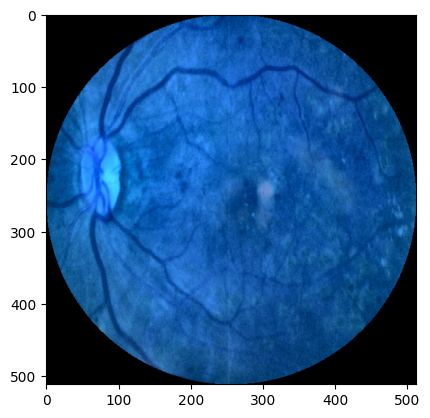

In [123]:
ima=preprocess_aptos_image("./0ad36156ad5d.png")
plt.imshow(ima)

In [131]:
# Apply preprocessing to the images in the dataset
train_df["file_path"] = train_df["id_code"].apply(
    lambda x: f"{base_dir}/train_images/{x}.png"
)
train_df["processed_image"] = train_df["file_path"].apply(preprocess_aptos_image)

test_df["file_path"] = test_df["id_code"].apply(
    lambda x: f"{base_dir}/test_images/{x}.png"
)
test_df["processed_image"] = test_df["file_path"].apply(preprocess_aptos_image)

# Split the training data into train and validation sets
t_df, val_df = train_test_split(
    train_df, test_size=0.9, stratify=train_df["diagnosis"]
)


In [185]:
# Ensure the 'diagnosis' column is a string for categorical processing
train_df['diagnosis'] = train_df['diagnosis'].astype(str)
val_df['diagnosis'] = val_df['diagnosis'].astype(str)

# Image data generators for data augmentation and rescaling
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

In [186]:
# Set image size and batch size
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 32

In [187]:
# Create data generators for training and validation datasets
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',
    y_col='diagnosis',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='file_path',
    y_col='diagnosis',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 4985 validated image filenames belonging to 5 classes.
Found 4487 validated image filenames belonging to 5 classes.


In [188]:
# Data generator for the test dataset (no labels required)
test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col=None,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False
)

Found 1928 validated image filenames.


In [189]:
# Number of epochs for training
EPOCHS = 30

In [190]:
# Function to create the model
def create_model(base_model, input_shape=(224, 224, 3)):
    model = Sequential(
        [
            base_model,
            Flatten(),
            BatchNormalization(),
            Dense(512, activation="relu", kernel_regularizer='l2'),
            Dropout(0.5),
            BatchNormalization(),
            Dense(5, activation="softmax"),
        ]
    )
    return model

In [191]:
# Function to evaluate the model's performance
def evaluate_model(model, val_generator):
    # Predicting on the validation data
    val_generator.reset()
    val_preds = model.predict(val_generator, steps=len(val_generator), verbose=1)
    val_pred_classes = np.argmax(val_preds, axis=1)
    
    val_true_classes = val_generator.classes

    accuracy = accuracy_score(val_true_classes, val_pred_classes)
    precision = precision_score(val_true_classes, val_pred_classes, average='weighted')
    recall = recall_score(val_true_classes, val_pred_classes, average='weighted')
    f1 = f1_score(val_true_classes, val_pred_classes, average='weighted')
    conf_matrix = confusion_matrix(val_true_classes, val_pred_classes)
    class_report = classification_report(val_true_classes, val_pred_classes)
    
    return accuracy, precision, recall, f1, conf_matrix, class_report

In [192]:
# Function to plot the training history
def plot_history(history, model_name):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [193]:
# Learning rate scheduler and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [194]:
# Define the models separately for individual training
mobilenet_model = MobileNet(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
xception_model = Xception(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
resnet50v2_model = ResNet50V2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
densenet201_model = DenseNet201(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
densenet169_model = DenseNet169(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
inceptionv3_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
inceptionresnetv2_model = InceptionResNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

In [195]:
# Create the models using the base models defined above
mobilenet = create_model(mobilenet_model)
xception = create_model(xception_model)
resnet50v2 = create_model(resnet50v2_model)
densenet201 = create_model(densenet201_model)
densenet169 = create_model(densenet169_model)
inceptionv3 = create_model(inceptionv3_model)
inceptionresnetv2 = create_model(inceptionresnetv2_model)

In [197]:
# Compile the models with Adam optimizer and categorical crossentropy loss
mobilenet.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy",Precision(name='precision'), Recall(name='recall')])
xception.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy",Precision(name='precision'), Recall(name='recall')])
resnet50v2.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy",Precision(name='precision'), Recall(name='recall')])
densenet201.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy",Precision(name='precision'), Recall(name='recall')])
densenet169.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy",Precision(name='precision'), Recall(name='recall')])
inceptionv3.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy",Precision(name='precision'), Recall(name='recall')])
inceptionresnetv2.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy",Precision(name='precision'), Recall(name='recall')])

Training MobileNet model...
Epoch 1/30


c:\Users\User\Desktop\from pendrive\Thesis\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


155/155 ━━━━━━━━━━━━━━━━━━━━ 632s 4s/step - accuracy: 0.6215 - loss: 10.9591 - precision: 0.6468 - recall: 0.5759 - val_accuracy: 0.6694 - val_loss: 2.9216 - val_precision: 0.6933 - val_recall: 0.6444 - learning_rate: 0.0010
Epoch 2/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5938 - loss: 2.8755 - precision: 0.6552 - recall: 0.5938 - val_accuracy: 0.8571 - val_loss: 2.4504 - val_precision: 0.8571 - val_recall: 0.8571 - learning_rate: 0.0010


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1520.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


Epoch 3/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 618s 4s/step - accuracy: 0.7142 - loss: 2.3720 - precision: 0.7648 - recall: 0.6701 - val_accuracy: 0.7444 - val_loss: 1.8554 - val_precision: 0.7735 - val_recall: 0.7212 - learning_rate: 0.0010
Epoch 4/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 817us/step - accuracy: 0.7188 - loss: 1.9232 - precision: 0.7586 - recall: 0.6875 - val_accuracy: 0.7143 - val_loss: 1.9774 - val_precision: 0.7143 - val_recall: 0.7143 - learning_rate: 0.0010
Epoch 5/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 616s 4s/step - accuracy: 0.7452 - loss: 1.8527 - precision: 0.7809 - recall: 0.6913 - val_accuracy: 0.7199 - val_loss: 1.8085 - val_precision: 0.7560 - val_recall: 0.6721 - learning_rate: 0.0010
Epoch 6/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 822us/step - accuracy: 0.8438 - loss: 1.4755 - precision: 0.8621 - recall: 0.7812 - val_accuracy: 0.5714 - val_loss: 2.1849 - val_precision: 0.5714 - val_recall: 0.5714 - learning_rate: 0.0010
Epoch 7/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 614s 4s/step - acc

Final Training Accuracy: 0.9375
Final Validation Accuracy: 1.0
Final Training Precision: 0.9354838728904724
Final Validation Precision: 1.0
Final Training Recall: 0.90625
Final Validation Recall: 1.0
Final Training F1-Score: 0.9206349215660086
Final Validation F1-Score: 1.0
Final Training Loss: 0.7588527202606201
Final Validation Loss: 0.333527147769928


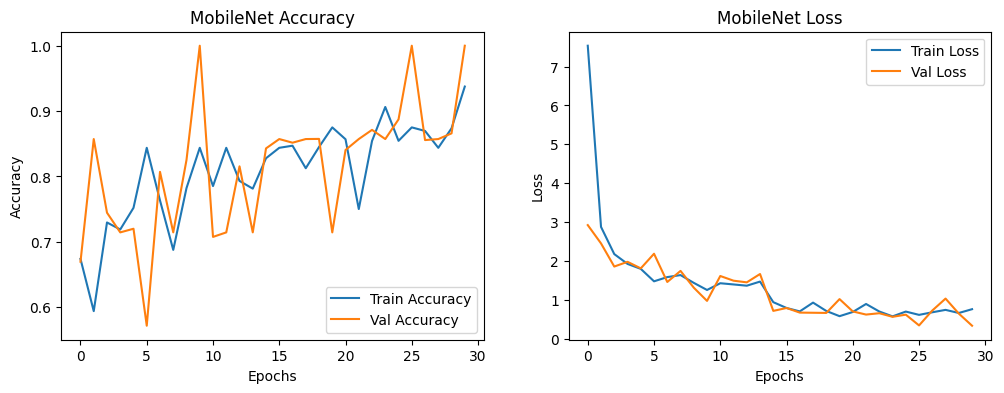

In [144]:
# 1. MobileNet
print("Training MobileNet model...")
mobilenet_history = mobilenet.fit(
    train_generator,
    steps_per_epoch=len(train_df) // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=len(val_df) // BATCH_SIZE,
    epochs=EPOCHS,
     callbacks=[reduce_lr, early_stopping],
    verbose=1,
)

# Save the trained model
mobilenet.save("MobileNet_model.h5")

# Extract final metrics from history
train_accuracy = mobilenet_history.history['accuracy'][-1]
val_accuracy = mobilenet_history.history['val_accuracy'][-1]
train_precision = mobilenet_history.history['precision'][-1]
val_precision = mobilenet_history.history['val_precision'][-1]
train_recall = mobilenet_history.history['recall'][-1]
val_recall = mobilenet_history.history['val_recall'][-1]
train_loss = mobilenet_history.history['loss'][-1]
val_loss = mobilenet_history.history['val_loss'][-1]

# Calculate F1-score for train and validation data
train_f1 = 2 * (train_precision * train_recall) / (train_precision + train_recall)
val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall)

# Print the final metrics
print("Final Training Accuracy:", train_accuracy)
print("Final Validation Accuracy:", val_accuracy)
print("Final Training Precision:", train_precision)
print("Final Validation Precision:", val_precision)
print("Final Training Recall:", train_recall)
print("Final Validation Recall:", val_recall)
print("Final Training F1-Score:", train_f1)
print("Final Validation F1-Score:", val_f1)
print("Final Training Loss:", train_loss)
print("Final Validation Loss:", val_loss)

# Plot the training history (including accuracy and loss)
plot_history(mobilenet_history, "MobileNet")

In [201]:
EPOCHS=20

Training Xception model...
Epoch 1/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 795s 5s/step - accuracy: 0.8389 - loss: 1.1571 - precision: 0.8643 - recall: 0.8139 - val_accuracy: 0.8730 - val_loss: 0.9849 - val_precision: 0.9000 - val_recall: 0.8455 - learning_rate: 0.0010
Epoch 2/20
  1/155 ━━━━━━━━━━━━━━━━━━━━ 5:38 2s/step - accuracy: 0.8438 - loss: 1.0131 - precision: 0.8438 - recall: 0.8438

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1520.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8438 - loss: 1.0131 - precision: 0.8438 - recall: 0.8438 - val_accuracy: 1.0000 - val_loss: 0.8483 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 789s 5s/step - accuracy: 0.8546 - loss: 1.1251 - precision: 0.8737 - recall: 0.8316 - val_accuracy: 0.7725 - val_loss: 1.3743 - val_precision: 0.8045 - val_recall: 0.7411 - learning_rate: 0.0010
Epoch 4/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7812 - loss: 1.3525 - precision: 0.7812 - recall: 0.7812 - val_accuracy: 0.5714 - val_loss: 1.6728 - val_precision: 0.6000 - val_recall: 0.4286 - learning_rate: 0.0010
Epoch 5/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 789s 5s/step - accuracy: 0.8530 - loss: 1.2163 - precision: 0.8796 - recall: 0.8349 - val_accuracy: 0.8161 - val_loss: 1.3134 - val_precision: 0.8467 - val_recall: 0.7826 - learning_rate: 0.0010
Epoch 6/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8438 - 

Final Training Accuracy: 0.9375
Final Validation Accuracy: 0.8571428656578064
Final Training Precision: 0.9375
Final Validation Precision: 0.8571428656578064
Final Training Recall: 0.9375
Final Validation Recall: 0.8571428656578064
Final Training F1-Score: 0.9375
Final Validation F1-Score: 0.8571428656578064
Final Training Loss: 0.1500823199748993
Final Validation Loss: 0.5231663584709167


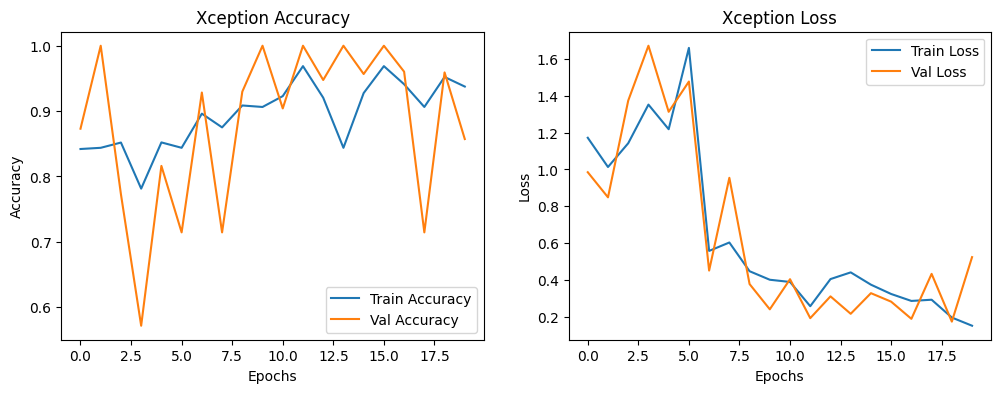

In [153]:
# 2. Xception
print("Training Xception model...")
xception_history = xception.fit(
    train_generator,
    steps_per_epoch=len(train_df) // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=len(val_df) // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[reduce_lr],
    verbose=1,
)

# Save the trained model
xception.save("Xception_model.h5")

# Extract final metrics from history
train_accuracy = xception_history.history['accuracy'][-1]
val_accuracy = xception_history.history['val_accuracy'][-1]
train_precision = xception_history.history['precision'][-1]
val_precision = xception_history.history['val_precision'][-1]
train_recall = xception_history.history['recall'][-1]
val_recall = xception_history.history['val_recall'][-1]
train_loss = xception_history.history['loss'][-1]
val_loss = xception_history.history['val_loss'][-1]

# Calculate F1-score for train and validation data
train_f1 = 2 * (train_precision * train_recall) / (train_precision + train_recall)
val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall)

# Print the final metrics
print("Final Training Accuracy:", train_accuracy)
print("Final Validation Accuracy:", val_accuracy)
print("Final Training Precision:", train_precision)
print("Final Validation Precision:", val_precision)
print("Final Training Recall:", train_recall)
print("Final Validation Recall:", val_recall)
print("Final Training F1-Score:", train_f1)
print("Final Validation F1-Score:", val_f1)
print("Final Training Loss:", train_loss)
print("Final Validation Loss:", val_loss)

# Plot the training history (including accuracy and loss)
plot_history(xception_history, "Xception")

In [180]:
x, y = next(train_generator)
print(x.shape, y.shape)


(32, 224, 224, 3) (32, 5)


Training ResNet50V2 model...
Epoch 1/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 736s 5s/step - accuracy: 0.5025 - loss: 8.4012 - precision: 0.5944 - recall: 0.4213 - val_accuracy: 0.3855 - val_loss: 1255.5762 - val_precision: 0.3888 - val_recall: 0.3725 - learning_rate: 0.0010
Epoch 2/20
  1/155 ━━━━━━━━━━━━━━━━━━━━ 4:09 2s/step - accuracy: 0.4688 - loss: 3.2104 - precision: 0.6667 - recall: 0.3750

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1520.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4688 - loss: 3.2104 - precision: 0.6667 - recall: 0.3750 - val_accuracy: 0.4286 - val_loss: 210.4018 - val_precision: 0.4286 - val_recall: 0.4286 - learning_rate: 0.0010
Epoch 3/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 728s 5s/step - accuracy: 0.4988 - loss: 3.1655 - precision: 0.6568 - recall: 0.3705 - val_accuracy: 0.4938 - val_loss: 3.0413 - val_precision: 0.8431 - val_recall: 0.3107 - learning_rate: 0.0010
Epoch 4/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6250 - loss: 2.8859 - precision: 0.7778 - recall: 0.4375 - val_accuracy: 0.2857 - val_loss: 3.1818 - val_precision: 0.6667 - val_recall: 0.2857 - learning_rate: 0.0010
Epoch 5/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 731s 5s/step - accuracy: 0.5694 - loss: 3.0751 - precision: 0.7502 - recall: 0.4279 - val_accuracy: 0.3748 - val_loss: 10.1079 - val_precision: 0.4522 - val_recall: 0.3228 - learning_rate: 0.0010
Epoch 6/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4688

Final Training Accuracy: 0.6875
Final Validation Accuracy: 0.8571428656578064
Final Training Precision: 0.8260869383811951
Final Validation Precision: 0.75
Final Training Recall: 0.59375
Final Validation Recall: 0.4285714328289032
Final Training F1-Score: 0.690909084564398
Final Validation F1-Score: 0.545454548902748
Final Training Loss: 1.0471856594085693
Final Validation Loss: 1.1044906377792358


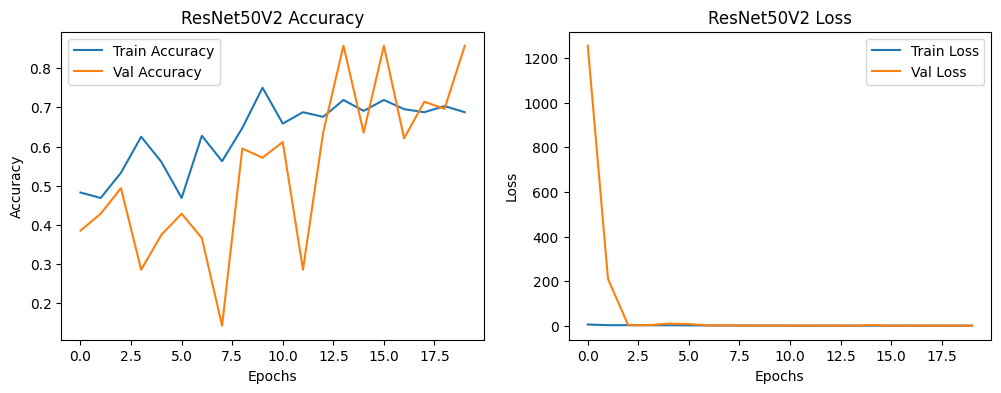

In [203]:
# 3. ResNet50V2
print("Training ResNet50V2 model...")
resnet50v2_history = resnet50v2.fit(
    train_generator,
    steps_per_epoch=len(train_df) // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=len(val_df) // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[reduce_lr],
    verbose=1,
)

# Save the trained model
resnet50v2.save("ResNet50V2_model.h5")

# Extract final metrics from history
train_accuracy = resnet50v2_history.history['accuracy'][-1]
val_accuracy = resnet50v2_history.history['val_accuracy'][-1]
train_precision = resnet50v2_history.history['precision'][-1]
val_precision = resnet50v2_history.history['val_precision'][-1]
train_recall = resnet50v2_history.history['recall'][-1]
val_recall = resnet50v2_history.history['val_recall'][-1]
train_loss = resnet50v2_history.history['loss'][-1]
val_loss = resnet50v2_history.history['val_loss'][-1]

# Calculate F1-score for train and validation data
train_f1 = 2 * (train_precision * train_recall) / (train_precision + train_recall)
val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall)

# Print the final metrics
print("Final Training Accuracy:", train_accuracy)
print("Final Validation Accuracy:", val_accuracy)
print("Final Training Precision:", train_precision)
print("Final Validation Precision:", val_precision)
print("Final Training Recall:", train_recall)
print("Final Validation Recall:", val_recall)
print("Final Training F1-Score:", train_f1)
print("Final Validation F1-Score:", val_f1)
print("Final Training Loss:", train_loss)
print("Final Validation Loss:", val_loss)

# Plot the training history (including accuracy and loss)
plot_history(resnet50v2_history, "ResNet50V2")

Training DenseNet201 model...
Epoch 1/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 911s 6s/step - accuracy: 0.6172 - loss: 2.7043 - precision: 0.6863 - recall: 0.5343 - val_accuracy: 0.6498 - val_loss: 2.0620 - val_precision: 0.6798 - val_recall: 0.6219 - learning_rate: 0.0010
Epoch 2/20
  1/155 ━━━━━━━━━━━━━━━━━━━━ 8:45 3s/step - accuracy: 0.7500 - loss: 1.6486 - precision: 0.8571 - recall: 0.7500

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1520.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7500 - loss: 1.6486 - precision: 0.8571 - recall: 0.7500 - val_accuracy: 0.7143 - val_loss: 1.8428 - val_precision: 0.8000 - val_recall: 0.5714 - learning_rate: 0.0010
Epoch 3/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 914s 6s/step - accuracy: 0.6891 - loss: 1.7119 - precision: 0.7607 - recall: 0.6161 - val_accuracy: 0.7458 - val_loss: 1.5446 - val_precision: 0.8380 - val_recall: 0.6560 - learning_rate: 0.0010
Epoch 4/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6250 - loss: 1.6817 - precision: 0.6667 - recall: 0.5625 - val_accuracy: 0.7143 - val_loss: 1.4679 - val_precision: 1.0000 - val_recall: 0.7143 - learning_rate: 0.0010
Epoch 5/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 915s 6s/step - accuracy: 0.7313 - loss: 1.4719 - precision: 0.7917 - recall: 0.6625 - val_accuracy: 0.7634 - val_loss: 1.3847 - val_precision: 0.8422 - val_recall: 0.6801 - learning_rate: 0.0010
Epoch 6/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6875 - 

Final Training Accuracy: 0.90625
Final Validation Accuracy: 1.0
Final Training Precision: 0.8965517282485962
Final Validation Precision: 1.0
Final Training Recall: 0.8125
Final Validation Recall: 1.0
Final Training F1-Score: 0.8524590182515825
Final Validation F1-Score: 1.0
Final Training Loss: 0.4585385024547577
Final Validation Loss: 0.2098221629858017


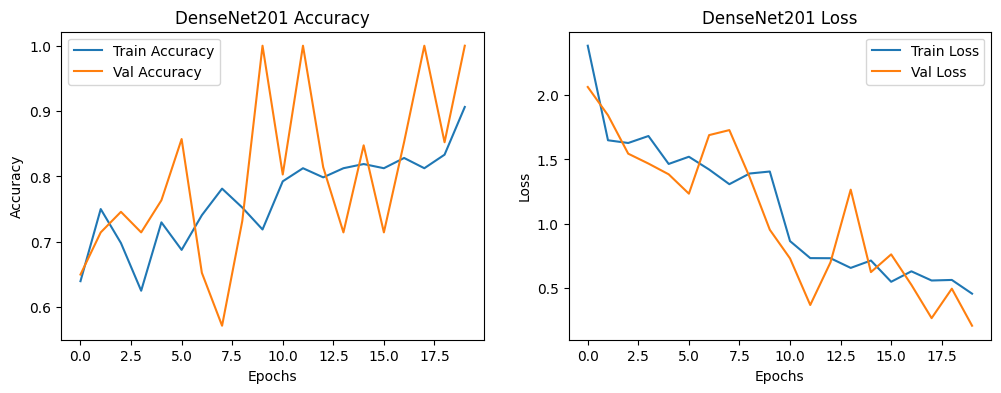

In [160]:
# 4. DenseNet201
print("Training DenseNet201 model...")
densenet201_history = densenet201.fit(
    train_generator,
    steps_per_epoch=len(train_df) // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=len(val_df) // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[reduce_lr],
    verbose=1,
)

# Save the trained model
densenet201.save("DenseNet201_model.h5")

# Extract final metrics from history
train_accuracy = densenet201_history.history['accuracy'][-1]
val_accuracy = densenet201_history.history['val_accuracy'][-1]
train_precision = densenet201_history.history['precision'][-1]
val_precision = densenet201_history.history['val_precision'][-1]
train_recall = densenet201_history.history['recall'][-1]
val_recall = densenet201_history.history['val_recall'][-1]
train_loss = densenet201_history.history['loss'][-1]
val_loss = densenet201_history.history['val_loss'][-1]

# Calculate F1-score for train and validation data
train_f1 = 2 * (train_precision * train_recall) / (train_precision + train_recall)
val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall)

# Print the final metrics
print("Final Training Accuracy:", train_accuracy)
print("Final Validation Accuracy:", val_accuracy)
print("Final Training Precision:", train_precision)
print("Final Validation Precision:", val_precision)
print("Final Training Recall:", train_recall)
print("Final Validation Recall:", val_recall)
print("Final Training F1-Score:", train_f1)
print("Final Validation F1-Score:", val_f1)
print("Final Training Loss:", train_loss)
print("Final Validation Loss:", val_loss)

# Plot the training history (including accuracy and loss)
plot_history(densenet201_history, "DenseNet201")

Training DenseNet169 model...
Epoch 1/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 833s 5s/step - accuracy: 0.7020 - loss: 1.7131 - precision: 0.7617 - recall: 0.6375 - val_accuracy: 0.6634 - val_loss: 2.9710 - val_precision: 0.7250 - val_recall: 0.5902 - learning_rate: 0.0010
Epoch 2/20
  1/155 ━━━━━━━━━━━━━━━━━━━━ 6:53 3s/step - accuracy: 0.7188 - loss: 2.0637 - precision: 0.7778 - recall: 0.6562

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1520.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7188 - loss: 2.0637 - precision: 0.7778 - recall: 0.6562 - val_accuracy: 0.7143 - val_loss: 2.2384 - val_precision: 0.6667 - val_recall: 0.5714 - learning_rate: 0.0010
Epoch 3/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 840s 5s/step - accuracy: 0.6998 - loss: 2.0364 - precision: 0.7620 - recall: 0.6257 - val_accuracy: 0.7694 - val_loss: 1.5202 - val_precision: 0.8460 - val_recall: 0.6844 - learning_rate: 0.0010
Epoch 4/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8125 - loss: 1.4113 - precision: 0.8387 - recall: 0.8125 - val_accuracy: 0.4286 - val_loss: 2.2429 - val_precision: 0.5000 - val_recall: 0.4286 - learning_rate: 0.0010
Epoch 5/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 843s 5s/step - accuracy: 0.7232 - loss: 1.6020 - precision: 0.7812 - recall: 0.6574 - val_accuracy: 0.7589 - val_loss: 2.5594 - val_precision: 0.8295 - val_recall: 0.6754 - learning_rate: 0.0010
Epoch 6/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5625 - 

Final Training Accuracy: 0.75
Final Validation Accuracy: 0.8571428656578064
Final Training Precision: 0.800000011920929
Final Validation Precision: 1.0
Final Training Recall: 0.75
Final Validation Recall: 0.8571428656578064
Final Training F1-Score: 0.7741935539692175
Final Validation F1-Score: 0.923076928014586
Final Training Loss: 0.7739486694335938
Final Validation Loss: 0.47083187103271484


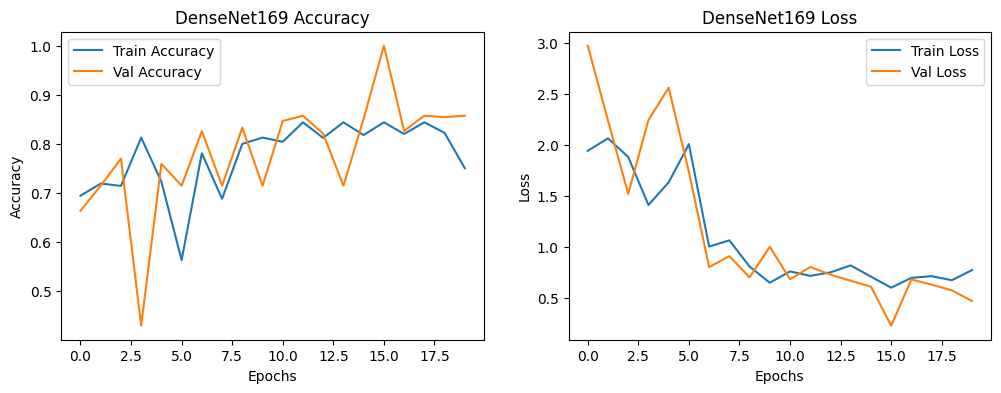

In [163]:
# 5. DenseNet169
print("Training DenseNet169 model...")
densenet169_history = densenet169.fit(
    train_generator,
    steps_per_epoch=len(train_df) // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=len(val_df) // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[reduce_lr],
    verbose=1,
)

# Save the trained model
densenet169.save("DenseNet169_model.h5")

# Extract final metrics from history
train_accuracy = densenet169_history.history['accuracy'][-1]
val_accuracy = densenet169_history.history['val_accuracy'][-1]
train_precision = densenet169_history.history['precision'][-1]
val_precision = densenet169_history.history['val_precision'][-1]
train_recall = densenet169_history.history['recall'][-1]
val_recall = densenet169_history.history['val_recall'][-1]
train_loss = densenet169_history.history['loss'][-1]
val_loss = densenet169_history.history['val_loss'][-1]

# Calculate F1-score for train and validation data
train_f1 = 2 * (train_precision * train_recall) / (train_precision + train_recall)
val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall)

# Print the final metrics
print("Final Training Accuracy:", train_accuracy)
print("Final Validation Accuracy:", val_accuracy)
print("Final Training Precision:", train_precision)
print("Final Validation Precision:", val_precision)
print("Final Training Recall:", train_recall)
print("Final Validation Recall:", val_recall)
print("Final Training F1-Score:", train_f1)
print("Final Validation F1-Score:", val_f1)
print("Final Training Loss:", train_loss)
print("Final Validation Loss:", val_loss)

# Plot the training history (including accuracy and loss)
plot_history(densenet169_history, "DenseNet169")

Training InceptionV3 model...
Epoch 1/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 688s 4s/step - accuracy: 0.5318 - loss: 9.8929 - precision: 0.6162 - recall: 0.4466 - val_accuracy: 0.5279 - val_loss: 1.9795 - val_precision: 0.8616 - val_recall: 0.2891 - learning_rate: 0.0010
Epoch 2/20
  1/155 ━━━━━━━━━━━━━━━━━━━━ 2:23 931ms/step - accuracy: 0.5625 - loss: 2.0124 - precision: 0.7273 - recall: 0.5000

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1520.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5625 - loss: 2.0124 - precision: 0.7273 - recall: 0.5000 - val_accuracy: 1.0000 - val_loss: 1.6935 - val_precision: 1.0000 - val_recall: 0.1429 - learning_rate: 0.0010
Epoch 3/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 662s 4s/step - accuracy: 0.6907 - loss: 1.7012 - precision: 0.7633 - recall: 0.6077 - val_accuracy: 0.1165 - val_loss: 4.1605 - val_precision: 0.1536 - val_recall: 0.0647 - learning_rate: 0.0010
Epoch 4/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7500 - loss: 2.0479 - precision: 0.7778 - recall: 0.6562 - val_accuracy: 0.1429 - val_loss: 4.9163 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 657s 4s/step - accuracy: 0.6118 - loss: 2.4218 - precision: 0.7016 - recall: 0.5174 - val_accuracy: 0.1087 - val_loss: 424161.5000 - val_precision: 0.1087 - val_recall: 0.1087 - learning_rate: 0.0010
Epoch 6/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accura

Final Training Accuracy: 0.71875
Final Validation Accuracy: 0.8571428656578064
Final Training Precision: 0.8399999737739563
Final Validation Precision: 0.8571428656578064
Final Training Recall: 0.65625
Final Validation Recall: 0.8571428656578064
Final Training F1-Score: 0.7368420951731132
Final Validation F1-Score: 0.8571428656578064
Final Training Loss: 0.9801815152168274
Final Validation Loss: 0.5465867519378662


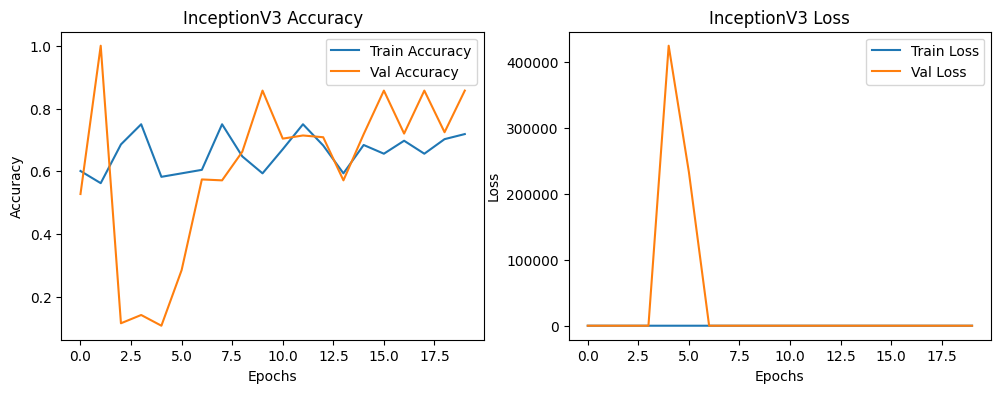

In [164]:
# 6. InceptionV3
print("Training InceptionV3 model...")
inceptionv3_history = inceptionv3.fit(
    train_generator,
    steps_per_epoch=len(train_df) // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=len(val_df) // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[reduce_lr],
    verbose=1,
)

# Save the trained model
inceptionv3.save("InceptionV3_model.h5")

# Extract final metrics from history
train_accuracy = inceptionv3_history.history['accuracy'][-1]
val_accuracy = inceptionv3_history.history['val_accuracy'][-1]
train_precision = inceptionv3_history.history['precision'][-1]
val_precision = inceptionv3_history.history['val_precision'][-1]
train_recall = inceptionv3_history.history['recall'][-1]
val_recall = inceptionv3_history.history['val_recall'][-1]
train_loss = inceptionv3_history.history['loss'][-1]
val_loss = inceptionv3_history.history['val_loss'][-1]

# Calculate F1-score for train and validation data
train_f1 = 2 * (train_precision * train_recall) / (train_precision + train_recall)
val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall)

# Print the final metrics
print("Final Training Accuracy:", train_accuracy)
print("Final Validation Accuracy:", val_accuracy)
print("Final Training Precision:", train_precision)
print("Final Validation Precision:", val_precision)
print("Final Training Recall:", train_recall)
print("Final Validation Recall:", val_recall)
print("Final Training F1-Score:", train_f1)
print("Final Validation F1-Score:", val_f1)
print("Final Training Loss:", train_loss)
print("Final Validation Loss:", val_loss)


# Plot the training history (including accuracy and loss)
plot_history(inceptionv3_history, "InceptionV3")

Training InceptionResNetV2 model...
Epoch 1/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 790s 5s/step - accuracy: 0.5957 - loss: 9.2453 - precision: 0.6458 - recall: 0.5375 - val_accuracy: 0.5971 - val_loss: 2.6008 - val_precision: 0.6777 - val_recall: 0.3891 - learning_rate: 0.0010
Epoch 2/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5938 - loss: 2.2791 - precision: 0.6667 - recall: 0.5625 - val_accuracy: 0.7143 - val_loss: 1.6883 - val_precision: 1.0000 - val_recall: 0.7143 - learning_rate: 0.0010
Epoch 3/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 717s 5s/step - accuracy: 0.6950 - loss: 1.8433 - precision: 0.7541 - recall: 0.6327 - val_accuracy: 0.7806 - val_loss: 1.4193 - val_precision: 0.8584 - val_recall: 0.6915 - learning_rate: 0.0010
Epoch 4/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7500 - loss: 1.6660 - precision: 0.7500 - recall: 0.7500 - val_accuracy: 1.0000 - val_loss: 0.9585 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 5/20
155/155 ━━━━━━━

Final Training Accuracy: 0.84375
Final Validation Accuracy: 0.7142857313156128
Final Training Precision: 0.84375
Final Validation Precision: 0.8333333134651184
Final Training Recall: 0.84375
Final Validation Recall: 0.7142857313156128
Final Training F1-Score: 0.84375
Final Validation F1-Score: 0.7692307706415297
Final Training Loss: 0.6003595590591431
Final Validation Loss: 0.43379831314086914


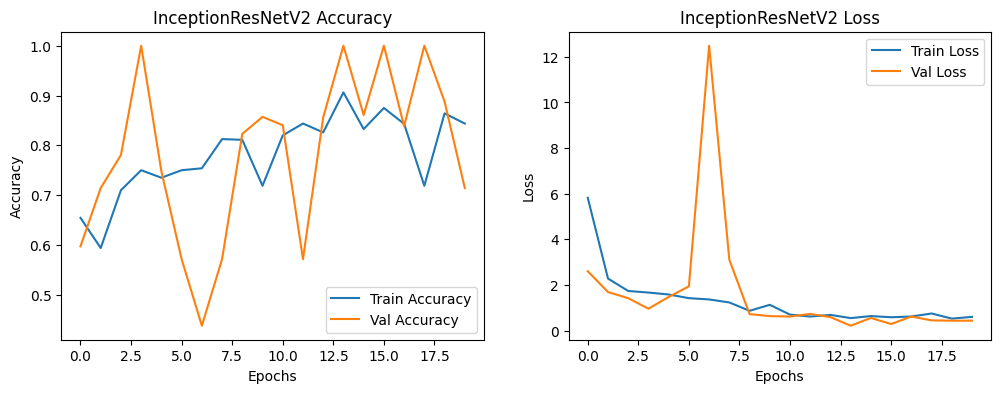

In [165]:
# 7. InceptionResNetV2
print("Training InceptionResNetV2 model...")
inceptionresnetv2_history = inceptionresnetv2.fit(
    train_generator,
    steps_per_epoch=len(train_df) // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=len(val_df) // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[reduce_lr],
    verbose=1,
)

# Save the trained model
inceptionresnetv2.save("InceptionResNetV2_model.h5")

# Extract final metrics from history
train_accuracy = inceptionresnetv2_history.history['accuracy'][-1]
val_accuracy = inceptionresnetv2_history.history['val_accuracy'][-1]
train_precision = inceptionresnetv2_history.history['precision'][-1]
val_precision = inceptionresnetv2_history.history['val_precision'][-1]
train_recall = inceptionresnetv2_history.history['recall'][-1]
val_recall = inceptionresnetv2_history.history['val_recall'][-1]
train_loss = inceptionresnetv2_history.history['loss'][-1]
val_loss = inceptionresnetv2_history.history['val_loss'][-1]

# Calculate F1-score for train and validation data
train_f1 = 2 * (train_precision * train_recall) / (train_precision + train_recall)
val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall)

# Print the final metrics
print("Final Training Accuracy:", train_accuracy)
print("Final Validation Accuracy:", val_accuracy)
print("Final Training Precision:", train_precision)
print("Final Validation Precision:", val_precision)
print("Final Training Recall:", train_recall)
print("Final Validation Recall:", val_recall)
print("Final Training F1-Score:", train_f1)
print("Final Validation F1-Score:", val_f1)
print("Final Training Loss:", train_loss)
print("Final Validation Loss:", val_loss)

# Plot the training history (including accuracy and loss)
plot_history(inceptionresnetv2_history, "InceptionResNetV2")

# Ensemble Models

In [214]:
from tensorflow.keras.models import load_model
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the trained models
mobilenet = load_model("MobileNet_model.h5")
xception = load_model("Xception_model.h5")
resnet50v2 = load_model("ResNet50V2_model.h5")
densenet201 = load_model("DenseNet201_model.h5")
densenet169 = load_model("DenseNet169_model.h5")
inceptionv3 = load_model("InceptionV3_model.h5")
# inceptionresnetv2 = load_model("InceptionResNetV2_model.h5")

# Function to predict using an ensemble of models
def ensemble_predict(models, generator):
    # Get predictions from each model
    preds = [model.predict(generator, steps=len(generator), verbose=1) for model in models]
    # Average the predictions (soft voting)
    avg_preds = np.mean(preds, axis=0)
    # Convert averaged predictions to class labels
    final_pred_classes = np.argmax(avg_preds, axis=1)
    return final_pred_classes

# List of models to be used in the ensemble
models = [mobilenet, xception, resnet50v2, densenet201, densenet169, inceptionv3]

# Predict on the validation data using the ensemble
val_generator.reset()
val_pred_classes = ensemble_predict(models, val_generator)

# Get the true class labels
val_true_classes = val_generator.classes

# Evaluate the ensemble model
accuracy = accuracy_score(val_true_classes, val_pred_classes)
precision = precision_score(val_true_classes, val_pred_classes, average='weighted')
recall = recall_score(val_true_classes, val_pred_classes, average='weighted')
f1 = f1_score(val_true_classes, val_pred_classes, average='weighted')

print("Ensemble Model Performance:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


141/141 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 278s 2s/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 279s 2s/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 296s 2s/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 285s 2s/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step
Ensemble Model Performance:
Accuracy: 0.2877200802317807
Precision: 0.2401463969661193
Recall: 0.2877200802317807
F1 Score: 0.24869258739760913
